# AAND BCI - Exercise Sheet #04

#### Name: Luke Longren

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import bci_minitoolbox as bci
import bci_classifiers as cfy

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15, 6)

## Exercise 1: Implementation of Shrinkage for Covariance Estimation  (4 points)
Implement a function `cov_shrink` that estimates the covariance matrix of data using shrinkage with the analytic method of determining the shrinkage coefficient as presented in the lecture. Input and output of that function should be as in the function `numpy.cov`.

If you cannot succeed with this task, you may import the function `cov_shrink` from `bci_helper_sheet4.pyc` (available at the moodle page) for the subsequent exercises.

## <font color='k'> $ \hat{\mu} = \frac{1}{K} \Sigma_{k=1}^K x_k $ , (emp. mean)

## <font color='k'>  $ \hat{\Sigma} = \frac{1}{K-1} \Sigma_{k=1}^K (x_k - \hat{\mu}) (x_k - \hat{\mu})^\top $ , (emp. covariance matrix)

## <font color='k'>  $ \tilde{\Sigma}(\gamma) = (1-\gamma) \hat{\Sigma} + \gamma \nu I $ , (with shrinkage)

In [3]:
def cov_shrink(X):
    '''
    Estimate covariance of given data using shrinkage estimator.
    
    Synopsis:
        C = cov_shrink(X)
    Argument:
        X: data matrix (features x samples)
    Output:
        C: estimated covariance matrix
    '''
    d = X.shape[0]  # number of features
    K = X.shape[1]  # number of samples
    # calculate the emp. mean of the data
    mean = np.zeros(d)
    for i in range(K):  # sum over samples
        mean += (1/K) * X[:,i]
    # calculate the emp. covariance
    cov = (1/(K-1)) * (X.T-mean).T @ (X.T-mean)
    # choose the optimal shrinkage coefficient gamma
    # done by minimizing the Frobenius norm of 
    # the difference between shrinkage cov. and the cov.
    Z_sum = 0
    for k in range(K):  # sum over samples
        # Z is the covariance matrix of a particular trial
        Z_sum += (X[:,k]-mean) @ (X[:,k]-mean).T
    Z_var = np.var(Z_sum)
    nu = (np.trace(cov) / d) * np.identity(d)  # average eigenvalue, times identity
    r = cov - nu
    r_sum = np.sum(r**2)
    gamma = (K/(K-1)**2) * Z_sum / r_sum
    # calculate with shrinkage
    cov_shrink = (1-gamma) * cov + (gamma * nu)
    return cov_shrink

## Exercise 2: Implementation of LDA with Shrinkage  (2 point)
Implement a function `train_LDAshrink` that calculates the LDA classifier in which the estimation of the covariance matrices is enhanced by shrinkage. Input and output should be the same as for `train_LDA` from sheet \#03. As for LDA, use the pseudo inverse (`numpy.linalg.pinv`) instead of the usual matrix inversion. 

If you cannot succeed with this task, you may import the function `train_LDAshrink` from `bci_cheat_sheet4.pyc` (available at the moodle page) for the subsequent exercises.

## <font color='k'>  $ w_{\gamma} = \tilde{\Sigma} (\gamma)^{-1} (\mu_2 - \mu_1) $ , (weight vector)

In [4]:
def train_LDAshrink(X, y):
    '''
    Synopsis:
        w, b = train_LDAshrink(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: LDA weight vector
        b: bias term
    '''
    # take the output of the cov_shrink function
    # in order to have the sigma(gamma)
    sigma = cov_shrink(X)
    # separate the two classes
    data1 = X[:, np.where(y == 0)]
    data2 = X[:, np.where(y == 1)]
    # find the means
    mu1 = np.mean(data1[:,0,:], axis=1)
    mu2 = np.mean(data2[:,0,:], axis=1)
    # calculate the weight vector and bias term
    w = np.linalg.pinv(sigma).dot(mu2 - mu1)
    b = w.T @ (mu1 + mu2) / 2
    return w, b

## Preparation: Load data

In [5]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)
print(cnt.shape, ', (features, samples)')

(55, 38710) , (features, samples)


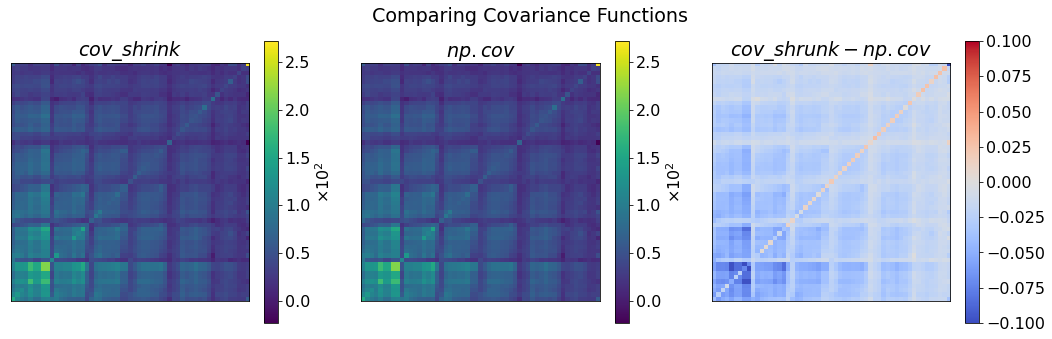

In [6]:
"""check that our implementation works by comparing to np.cov"""
fig, axs = plt.subplots(1, 3, figsize=(15,5))
ax1 = axs[0].imshow(cov_shrink(cnt)/10e2, origin='lower')
axs[0].set_title('$cov\_shrink$')
ax2 = axs[1].imshow(np.cov(cnt)/10e2, origin='lower')
axs[1].set_title('$np.cov$')
ax3 = plt.imshow(cov_shrink(cnt) - np.cov(cnt), origin='lower', 
                 cmap='coolwarm', vmin=-0.1, vmax=0.1)
axs[2].set_title('$cov\_shrunk - np.cov$')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
fig.colorbar(ax1, ax=axs[0], label=r'$\times 10^2$')
fig.colorbar(ax2, ax=axs[1], label=r'$\times 10^2$')
fig.colorbar(ax3, ax=axs[2])
plt.suptitle('Comparing Covariance Functions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [7]:
"""check that our implementation works by comparing to train_LDA"""
# we shall just compare for all time points
time_ival = [0, 1000]
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, time_ival)
channel_num = epo.shape[1]

loss_shrink = np.zeros(channel_num)
loss_compare = np.zeros(channel_num)
for i in range(channel_num):
    loss_shrink[i], _ = cfy.crossvalidation(train_LDAshrink, epo[:,i,:], mrk_class)
    loss_compare[i], _ = cfy.crossvalidation(cfy.train_LDA, epo[:,i,:], mrk_class)

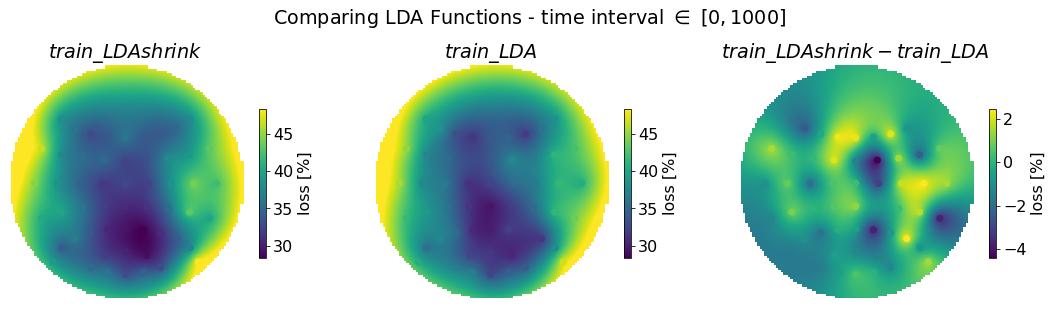

In [8]:
clim = [np.vstack((loss_shrink, loss_compare)).min(), np.vstack((loss_shrink, loss_compare)).max()]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
plt.sca(ax3)
#plt.set_cmap('coolwarm')  # not sure how to change both the scatter and imshow colormap
difference = loss_shrink-loss_compare
bci.scalpmap(mnt, difference, clim='minmax', cb_label='loss [%]')
#plt.scatter(mnt[:,0], mnt[:,1], c=difference, vmin=difference.min(), vmax=difference.max(), cmap='coolwarm')
plt.title('$train\_LDAshrink - train\_LDA$')
plt.sca(ax1)
plt.set_cmap('viridis')
bci.scalpmap(mnt, loss_shrink, clim=clim, cb_label='loss [%]')
plt.title('$train\_LDAshrink$')
plt.sca(ax2)
bci.scalpmap(mnt, loss_compare, clim=clim, cb_label='loss [%]')
plt.title('$train\_LDA$')
plt.suptitle('Comparing LDA Functions - time interval $\in \ [0, 1000]$')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Exercise 3: Classification of Spatio-Temporal Features  (4 points)
First, use the time-averaged potential in each of the intervals [ms]: 160-200, 200-220, 230-260, 260-290, 300-320, 330-370, 380-430, and 480-520 as feature vector (dimension 55 `x` 1) for each trial. For each interval calculate the 3-fold cross-validation error using LDA with and without shrinkage.

In a second step, concatenate the eight feature vectors, that were calculated for the eight specified intervals into one feature vector (dimension 440 `x` 1) for each trial. Again, determine the 3-fold cross-validation error using LDA with and without shrinkage.

Did the following first:

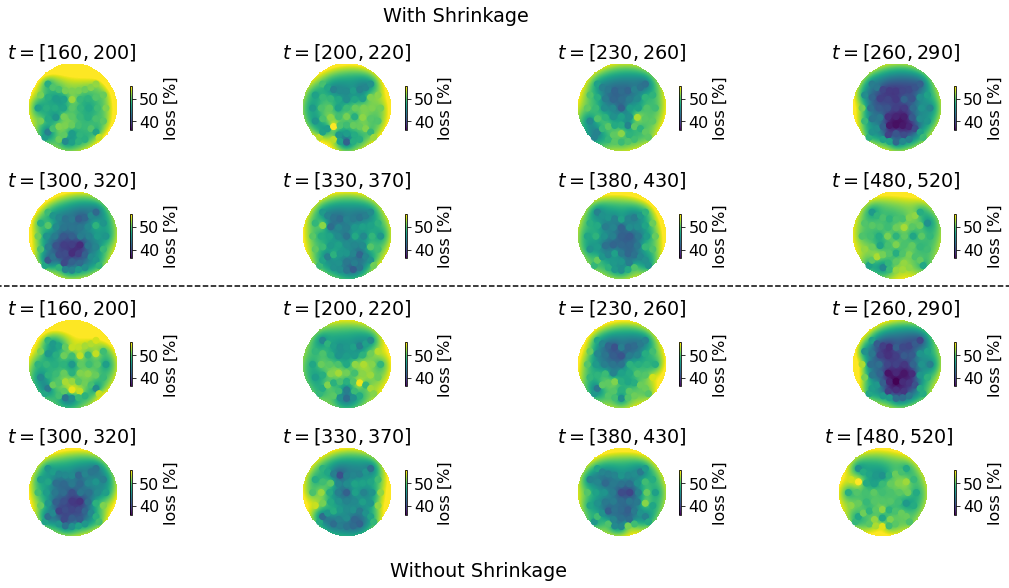

In [9]:
"""calculate the 3-fold error with and without shrinkage for each interval"""
ival = [[160, 200], [200, 220], [230, 260], [260, 290], [300, 320], [330, 370], [380, 430], [480, 520]]
loss_shrink = np.zeros((len(ival), channel_num))  # taking channel_num from previous
loss_compare = np.zeros((len(ival), channel_num))
for t in range(len(ival)):
    epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival=ival[t])
    for i in range(channel_num):
        # perform the 3-fold cross-validation for w/ and w/o shrinkage
        loss_shrink[t,i], _ = cfy.crossvalidation(train_LDAshrink, epo[:,i,:], mrk_class, folds=3)
        loss_compare[t,i], _ = cfy.crossvalidation(cfy.train_LDA, epo[:,i,:], mrk_class, folds=3)
        
clim = [np.vstack((loss_shrink, loss_compare)).min(), np.vstack((loss_shrink, loss_compare)).max()]
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
for i in range(len(ival)):
    plt.subplot(4, len(ival)//2, i+1)
    bci.scalpmap(mnt, loss_shrink[i], clim=clim, cb_label='loss [%]')
    plt.title('$t={}$'.format(ival[i]))
    plt.subplot(4, len(ival)//2, len(ival)+i+1)
    bci.scalpmap(mnt, loss_compare[i], clim=clim, cb_label='loss [%]')
    plt.title('$t={}$'.format(ival[i]))
plt.suptitle('With Shrinkage')
fig.text(0.52, 0, 'Without Shrinkage', ha='center', va='center', fontsize=plt.rcParams['axes.titlesize'])
plt.hlines(0.49, -0.2, 1.2, clip_on=False, transform=ax.transAxes, linestyle='--')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

And then decided to do this:

I know a lot of the above is unneeded, but that's where my mind went at first with the assignment.

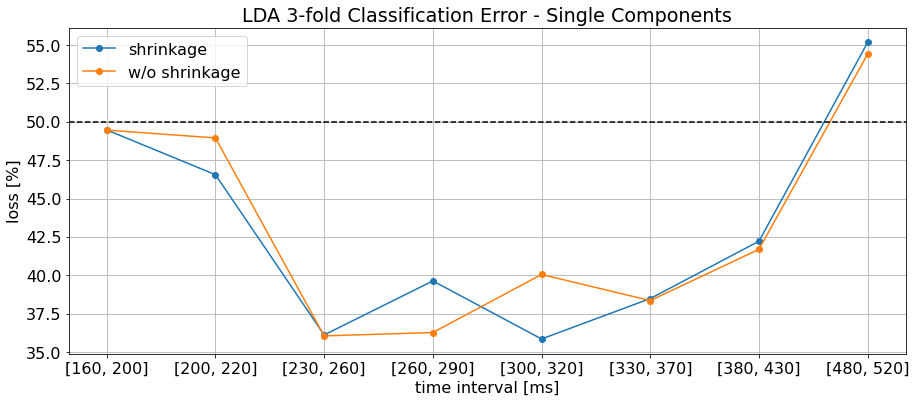

In [10]:
ival = [[160, 200], [200, 220], [230, 260], [260, 290], [300, 320], [330, 370], [380, 430], [480, 520]]
loss_shrink = np.zeros(len(ival))
loss_compare = np.zeros(len(ival))
for i in range(len(ival)):
    epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival[i])
    # perform the 3-fold cross-validation for w/ and w/o shrinkage
    loss_shrink[i], _ = cfy.crossvalidation(train_LDAshrink, epo.mean(axis=0), mrk_class, folds=3)
    loss_compare[i], _ = cfy.crossvalidation(cfy.train_LDA, epo.mean(axis=0), mrk_class, folds=3)
    
plt.plot(loss_shrink, marker='o', label='shrinkage')
plt.plot(loss_compare, marker='o', label='w/o shrinkage')
plt.title('LDA 3-fold Classification Error - Single Components')
plt.ylabel('loss [%]')
plt.xlabel('time interval [ms]')
plt.xticks(np.arange(0, 8, 1), ival)
plt.axhline(y=50, c='k', ls='--')
plt.legend()
plt.grid()
plt.show()

In [21]:
print('Average over the time intervals')
print('{:.3g}%, loss using shrinking'.format(loss_shrink.mean()))
print('{:.3g}%, loss without shrinking'.format(loss_compare.mean()))

Average over the time intervals
42.9%, loss using shrinking
43.2%, loss without shrinking


Showing roughly the same results with and without shrinking and using single time interval components.

In [22]:
"""concatenate the eight feature vectors for each trial, and determine error again"""
ct_vector = np.concatenate([bci.makeepochs(cnt, fs, mrk_pos, ival=ival[i])[0].mean(axis=0) for i in range(len(ival))])
print(ct_vector.shape, ', shape of the concatenated feature vector')

(440, 1200) , shape of the concatenated feature vector


In [26]:
ct_loss_shrink, _ = cfy.crossvalidation(train_LDAshrink, ct_vector, mrk_class, folds=3, verbose=False)
ct_loss_compare, _ = cfy.crossvalidation(cfy.train_LDA, ct_vector, mrk_class, folds=3)
print('Using the concatenated feature vector')
print('{:.3g}%, loss using shrinking'.format(ct_loss_shrink))
print('{:.3g}%, loss without shrinking'.format(ct_loss_compare))

Using the concatenated feature vector
27.5%, loss using shrinking
29.8%, loss without shrinking


Showing better results for this dataset using the shrinking method with concatenating.